In [2]:
%load_ext autoreload
%autoreload 2

import torch
from einops import rearrange
from text3d2video.artifacts.multiview_features_artifact import MVFeaturesArtifact
from text3d2video.wandb_util import first_used_artifact_of_type
from text3d2video.artifacts.animation_artifact import AnimationArtifact
from matplotlib import pyplot as plt
from text3d2video.visualization import RgbPcaUtil
import text3d2video.wandb_util as wu

In [3]:
mv_features_tag  = 'deadpool-mv-features:latest'

mv_features = wu.get_artifact(mv_features_tag)
mv_features = MVFeaturesArtifact.from_wandb_artifact(mv_features)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Downloading large artifact deadpool-mv-features:latest, 8846.59MB. 4330 files... 
wandb:   4330 of 4330 files downloaded.  
Done. 0:0:12.5


In [10]:
layers = mv_features.get_key_values('layer')
views = sorted([int(v) for v in mv_features.get_key_values('view')])
timesteps = sorted([int(t) for t in mv_features.get_key_values('timestep')])

In [23]:
from math import sqrt
from typing import List
from text3d2video.ipython_utils import display_ims

def display_features(features: List[torch.Tensor], separate_pca=False, scale=3):

    if separate_pca:
        feature_maps_rgb = []

        for feature in features:
            pca = RgbPcaUtil.init_and_fit(feature)
            feature_map_size = int(sqrt(feature.shape[0]))
            feature_map = rearrange(feature, '(h w) c -> c h w', h=feature_map_size)
            feature_map_rgb = pca.feature_map_to_rgb_pil(feature_map)
            feature_maps_rgb.append(feature_map_rgb)
        
        display_ims(feature_maps_rgb, scale=scale)
        return

    # get all features, and fit PCA
    all_features = torch.cat(features)
    pca = RgbPcaUtil.init_and_fit(all_features)

    # PCA each feature
    feature_maps_rgb = []
    for feature in features:
        feature_map_size = int(sqrt(feature.shape[0]))
        feature_map = rearrange(feature, '(h w) c -> c h w', h=feature_map_size)
        feature_map_rgb = pca.feature_map_to_rgb_pil(feature_map)
        feature_maps_rgb.append(feature_map_rgb)
    
    display_ims(feature_maps_rgb, scale=scale)

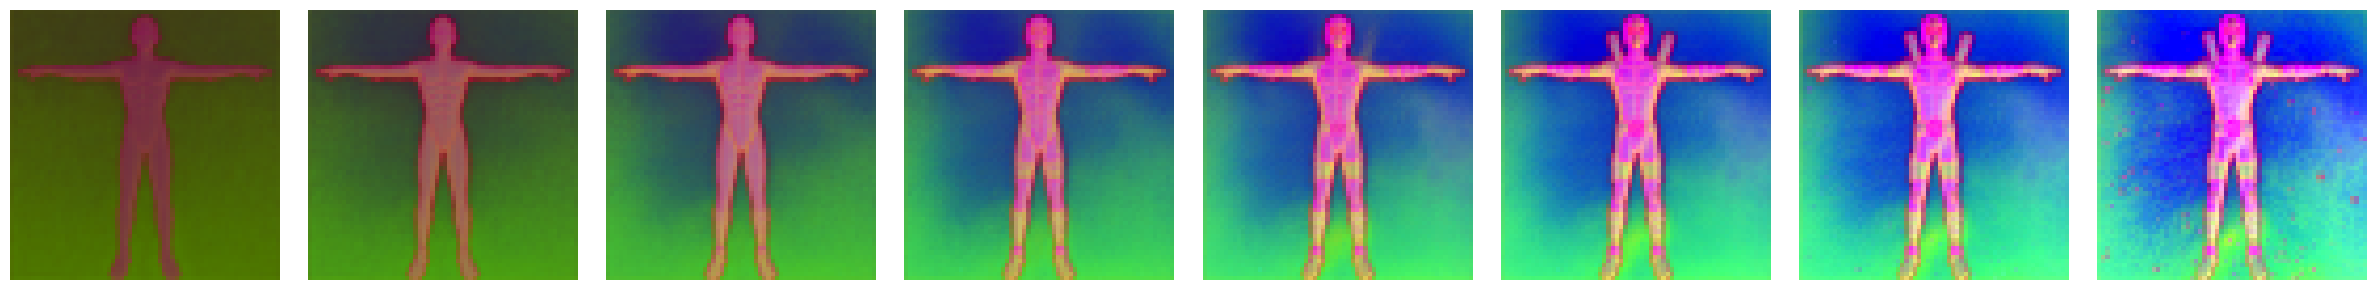

In [19]:
from text3d2video.util import ordered_sample

ids = [{'view': views[0], 'layer': layers[0], 'timestep': t} for t in ordered_sample(timesteps, 8)]
features = [mv_features.get_feature_by_id(i) for i in ids]
display_features(features)

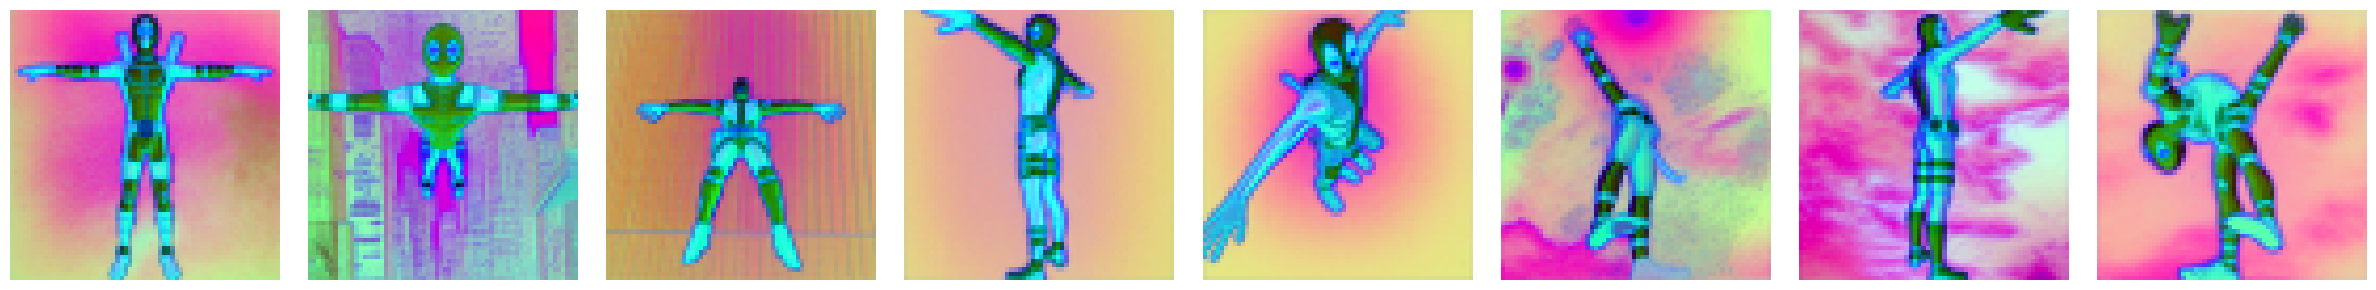

In [20]:
ids = [{'view': v, 'layer': layers[0], 'timestep': timesteps[20]} for v in ordered_sample(views, 8)]
features = [mv_features.get_feature_by_id(i) for i in ids]
display_features(features)

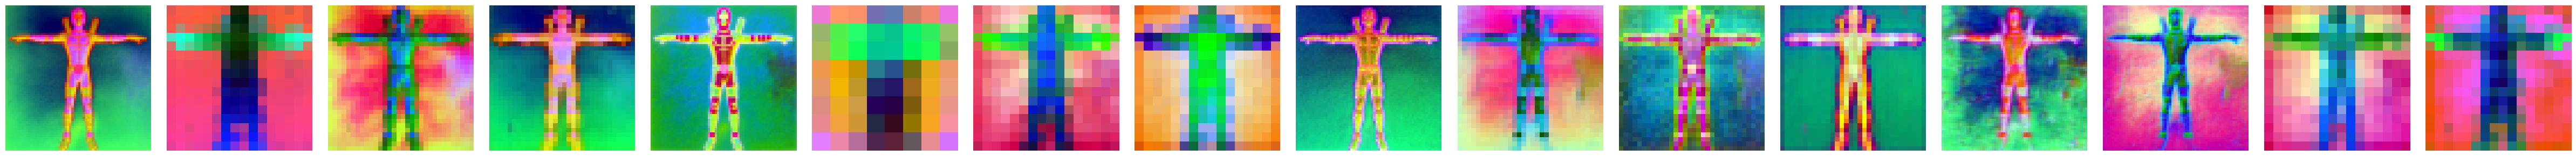

In [24]:
ids = [{'view': views[0], 'layer': l, 'timestep': timesteps[20]} for l in layers]
features = [mv_features.get_feature_by_id(i) for i in ids]

display_features(features, separate_pca=True)